# Cloudera AI - Hands-on-Learning Workshop
 
## Workshop Overview

Welcome to this hands-on workshop! Today we'll explore the complete machine learning lifecycle using Cloudera AI (CAI) platform, focusing on a License Plate Recognition (LPR) use case.

### What You'll Learn
- How to leverage Cloudera AI for rapid ML prototyping and operationalization
- Complete ML lifecycle: from data ingestion to deployment
- Best practices for computer vision projects
- Model experimentation, tracking, and deployment strategies

### Workshop Objectives
By the end of this workshop, you will:
1. Understand how to ingest and explore image datasets in CAI
2. Build and train a license plate recognition model
3. Evaluate and optimize model performance
4. Deploy your model as a REST API
5. Understand how to integrate with CAI's advanced features


##  Workshop Agenda

### **Part 1: Exploratory Data Analysis (EDA)**
- Data loading and inspection
- License plate crop extraction
- Data quality assessment
- Length distribution analysis
- Visualization and insights

### **Part 2: Model Building**
- CTC-based architecture design
- Data preprocessing pipeline
- Model training with variable-length support
- Validation and performance metrics
- Model optimization

### **Part 3: Model Serving**
- Model inference pipeline
- Real-time prediction system
- Performance benchmarking
- Deployment considerations


## 🚀 Why License Plate Recognition?

**Business Applications:**
- 🚗 Smart parking and toll systems
- 🔒 Security and access control
- 🏙️ Smart city traffic management
- 🚓 Law enforcement applications


**CAI Platform Benefits:**
- Scalable GPU resources for deep learning
- Built-in experiment tracking and model management
- Automated deployment pipelines
- Enterprise-grade monitoring and security


# PART 1: EXPLORATORY DATA ANALYSIS (EDA)

In this section, we'll explore our license plate dataset to understand:
1. Data structure and quality
2. License plate characteristics
3. Challenges for variable-length recognition
4. Data preprocessing requirements


In [2]:
# =============================================================================
# ENVIRONMENT SETUP AND IMPORTS
# =============================================================================

"""
Setting up the environment for variable-length license plate recognition.
We'll import all necessary libraries for data analysis, visualization, 
and deep learning with TensorFlow/Keras.
"""

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict
import random
import string
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Environment Setup Complete!")
print(f"   TensorFlow version: {tf.__version__}")
print(f"   Keras version: {keras.__version__}")
print(f"   NumPy version: {np.__version__}")
print(f"   OpenCV version: {cv2.__version__}")
print(f"   GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


Environment Setup Complete!
   TensorFlow version: 2.19.0
   Keras version: 3.10.0
   NumPy version: 2.1.3
   OpenCV version: 4.12.0
   GPU Available: False


In [9]:
import os
import glob
import cv2
import xml.etree.ElementTree as ET

# Try to import kagglehub for dataset download
try:
    import kagglehub

    print("Kagglehub available for dataset download")
except ImportError:
    print("Kagglehub not available - please install: pip install kagglehub")
    kagglehub = None

# =============================================================================
# DATASET DOWNLOAD AND SETUP
# =============================================================================


def download_dataset():
    """Download dataset using kagglehub if not already present."""

    DATASET_NAME = "andrewmvd/car-plate-detection"
    LOCAL_DATASET_PATH = "./lpr_data"

    print(" DATASET DOWNLOAD & SETUP")
    print("=" * 40)

    # Check if dataset already exists
    if os.path.exists(LOCAL_DATASET_PATH):
        images_dir = os.path.join(LOCAL_DATASET_PATH, "images")
        annotations_dir = os.path.join(LOCAL_DATASET_PATH, "annotations")

        if os.path.exists(images_dir) and os.path.exists(annotations_dir):
            print(f" Dataset already exists at: {LOCAL_DATASET_PATH}")
            return LOCAL_DATASET_PATH

    try:
        if kagglehub is not None:
            print(f" Downloading dataset: {DATASET_NAME}")

            # Download dataset
            dataset_path = kagglehub.dataset_download(DATASET_NAME)
            print(f" Dataset downloaded to: {dataset_path}")

            # Move to our preferred location if needed
            if dataset_path != LOCAL_DATASET_PATH:
                import shutil

                if os.path.exists(LOCAL_DATASET_PATH):
                    shutil.rmtree(LOCAL_DATASET_PATH)
                shutil.copytree(dataset_path, LOCAL_DATASET_PATH)
                print(f" Dataset copied to: {LOCAL_DATASET_PATH}")

            return LOCAL_DATASET_PATH

        else:
            print("Kagglehub not available - cannot download dataset")
            print("Please install kagglehub: pip install kagglehub")
            print(f"Or manually download dataset to: {LOCAL_DATASET_PATH}")
            return None

    except Exception as e:
        print(f" Dataset download failed: {e}")
        print("Please check your internet connection and kaggle credentials")
        return None


# =============================================================================
# DATASET DISCOVERY AND INITIAL INSPECTION
# =============================================================================

"""
Discovering and inspecting our license plate dataset structure.
We'll examine the Pascal VOC format annotations and corresponding images
to understand what data we're working with.
"""


def discover_dataset():
    """Discover and analyze the dataset structure."""

    # Dataset paths
    DATA_DIR = "lpr_data"
    IMAGES_DIR = os.path.join(DATA_DIR, "images")
    ANNOTATIONS_DIR = os.path.join(DATA_DIR, "annotations")

    print(" DATASET DISCOVERY")
    print("=" * 50)

    # Check if directories exist
    if not os.path.exists(DATA_DIR):
        print(" Dataset directory not found!")
        print(" Attempting to download dataset...")

        # Try to download dataset
        downloaded_path = download_dataset()
        if not downloaded_path:
            print(" Failed to download dataset")
            return None, None

        # Update paths after download
        DATA_DIR = downloaded_path
        IMAGES_DIR = os.path.join(DATA_DIR, "images")
        ANNOTATIONS_DIR = os.path.join(DATA_DIR, "annotations")

    # Get image and annotation files
    image_files = glob.glob(os.path.join(IMAGES_DIR, "*.png"))
    annotation_files = glob.glob(os.path.join(ANNOTATIONS_DIR, "*.xml"))

    print(f" Data Directory: {DATA_DIR}")
    print(f" Images found: {len(image_files)}")
    print(f" Annotations found: {len(annotation_files)}")

    # Check data consistency
    image_basenames = {os.path.splitext(os.path.basename(f))[0] for f in image_files}
    annotation_basenames = {
        os.path.splitext(os.path.basename(f))[0] for f in annotation_files
    }

    common_files = image_basenames.intersection(annotation_basenames)
    missing_images = annotation_basenames - image_basenames
    missing_annotations = image_basenames - annotation_basenames

    print(f" Paired files (image + annotation): {len(common_files)}")
    if missing_images:
        print(f" Missing images: {len(missing_images)}")
    if missing_annotations:
        print(f" Missing annotations: {len(missing_annotations)}")

    return sorted(list(common_files)), len(common_files)


def analyze_sample_files(file_list, num_samples=5):
    """Analyze a few sample files to understand the data structure."""

    # Dataset paths
    DATA_DIR = "lpr_data"
    IMAGES_DIR = os.path.join(DATA_DIR, "images")
    ANNOTATIONS_DIR = os.path.join(DATA_DIR, "annotations")

    print(f"\n SAMPLE FILE ANALYSIS ({num_samples} files)")
    print("=" * 50)

    for i, filename in enumerate(file_list[:num_samples]):
        print(f"\n Sample {i+1}: {filename}")

        # Analyze image
        img_path = os.path.join(IMAGES_DIR, f"{filename}.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                print(
                    f"   Image: {img.shape[1]}x{img.shape[0]} pixels, {img.shape[2]} channels"
                )
            else:
                print(f" Could not load image: {img_path}")
        else:
            print(f"  Image not found: {img_path}")

        # Analyze annotation
        xml_path = os.path.join(ANNOTATIONS_DIR, f"{filename}.xml")
        if os.path.exists(xml_path):
            try:
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Find license plate objects
                objects = root.findall("object")
                print(f"   Objects: {len(objects)} license plate(s) detected")

                for j, obj in enumerate(objects):
                    # Try different name tags (some files use 'name', others 'n')
                    name_elem = obj.find("name")
                    if name_elem is None:
                        name_elem = obj.find("n")

                    if name_elem is not None:
                        obj_class = name_elem.text
                        bbox = obj.find("bndbox")
                        if bbox is not None:
                            xmin_elem = bbox.find("xmin")
                            ymin_elem = bbox.find("ymin")
                            xmax_elem = bbox.find("xmax")
                            ymax_elem = bbox.find("ymax")

                            if all(
                                elem is not None and elem.text is not None
                                for elem in [xmin_elem, ymin_elem, xmax_elem, ymax_elem]
                            ):
                                # Type assertion since we've already checked None
                                xmin = int(xmin_elem.text or "0")
                                ymin = int(ymin_elem.text or "0")
                                xmax = int(xmax_elem.text or "0")
                                ymax = int(ymax_elem.text or "0")
                                width = xmax - xmin
                                height = ymax - ymin
                                print(
                                    f"     Object {j+1}: {obj_class} at ({xmin},{ymin}) to ({xmax},{ymax}) [{width}x{height}]"
                                )
                            else:
                                print(
                                    f"     Object {j+1}: {obj_class} - incomplete bounding box"
                                )
                    else:
                        print(
                            f"     Object {j+1}: Unknown class - no name element found"
                        )
            except Exception as e:
                print(f" Error parsing XML: {e}")
        else:
            print(f" Annotation not found: {xml_path}")


# =============================================================================
# MAIN EXECUTION
# =============================================================================

print(" LICENSE PLATE DATASET DISCOVERY")
print("=" * 60)

# Run dataset discovery
valid_files, total_files = discover_dataset()

if valid_files and len(valid_files) > 0:
    analyze_sample_files(valid_files)
    print(f"\n Dataset ready with {total_files} valid file pairs!")
else:
    print(
        "\n No valid dataset found. Please ensure lpr_data directory exists with images and annotations."
    )
    print(
        "   Or install kagglehub and run again to auto-download: pip install kagglehub"
    )


Kagglehub available for dataset download
 LICENSE PLATE DATASET DISCOVERY
 DATASET DISCOVERY
 Data Directory: lpr_data
 Images found: 433
 Annotations found: 433
 Paired files (image + annotation): 433

 SAMPLE FILE ANALYSIS (5 files)

 Sample 1: Cars0
   Image: 500x268 pixels, 3 channels
   Objects: 1 license plate(s) detected
     Object 1: licence at (226,125) to (419,173) [193x48]

 Sample 2: Cars1
   Image: 400x248 pixels, 3 channels
   Objects: 1 license plate(s) detected
     Object 1: licence at (134,128) to (262,160) [128x32]

 Sample 3: Cars10
   Image: 400x225 pixels, 3 channels
   Objects: 1 license plate(s) detected
     Object 1: licence at (140,5) to (303,148) [163x143]

 Sample 4: Cars100
   Image: 400x267 pixels, 3 channels
   Objects: 1 license plate(s) detected
     Object 1: licence at (175,114) to (214,131) [39x17]

 Sample 5: Cars101
   Image: 400x300 pixels, 3 channels
   Objects: 1 license plate(s) detected
     Object 1: licence at (167,202) to (240,220) [73x18

In [17]:
# =============================================================================
# LICENSE PLATE EXTRACTION AND ANALYSIS
# =============================================================================

"""
Extracting license plate crops from images using bounding box annotations.
This is crucial for understanding the actual license plate characteristics
and preparing data for our variable-length recognition model.
"""




def extract_license_plates(file_list, max_files=None):
    """Extract license plate crops from images using XML annotations."""

    # Dataset paths - adjust these to match your setup
    DATA_DIR = "lpr_data"
    IMAGES_DIR = os.path.join(DATA_DIR, "images")
    ANNOTATIONS_DIR = os.path.join(DATA_DIR, "annotations")

    print("🚗 EXTRACTING LICENSE PLATE CROPS")
    print("=" * 50)

    crops = []
    crop_info = []
    failed_extractions = 0

    files_to_process = file_list[:max_files] if max_files else file_list

    for i, filename in enumerate(files_to_process):
        if i % 50 == 0:
            print(f"   Processing: {i+1}/{len(files_to_process)} files...")

        try:
            # Load image
            img_path = os.path.join(IMAGES_DIR, f"{filename}.png")
            image = cv2.imread(img_path)

            if image is None:
                failed_extractions += 1
                continue

            # Parse XML annotation
            xml_path = os.path.join(ANNOTATIONS_DIR, f"{filename}.xml")
            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Extract license plate objects
            for obj in root.findall("object"):
                # CRITICAL FIX: Check <n> element first (dataset format), then fallback to <name>
                name_elem = obj.find("n")
                if name_elem is None:
                    name_elem = obj.find("name")

                # Check if this is a license plate object
                if name_elem is not None and name_elem.text is not None:
                    class_name = name_elem.text.lower().strip()
                    # Handle both "licence" (dataset format) and "license" (alternative)
                    if class_name in ["licence", "license"] or "licen" in class_name:
                        bbox = obj.find("bndbox")
                        if bbox is not None:
                            # Extract coordinates with safety checks
                            xmin_elem = bbox.find("xmin")
                            ymin_elem = bbox.find("ymin")
                            xmax_elem = bbox.find("xmax")
                            ymax_elem = bbox.find("ymax")

                            if all(
                                elem is not None and elem.text is not None
                                for elem in [xmin_elem, ymin_elem, xmax_elem, ymax_elem]
                            ):
                                # Parse coordinates safely (we've verified text is not None above)
                                xmin = max(0, int(float(xmin_elem.text or "0")))
                                ymin = max(0, int(float(ymin_elem.text or "0")))
                                xmax = min(
                                    image.shape[1], int(float(xmax_elem.text or "0"))
                                )
                                ymax = min(
                                    image.shape[0], int(float(ymax_elem.text or "0"))
                                )

                                # Validate bounding box
                                if xmax > xmin and ymax > ymin:
                                    # Extract crop
                                    crop = image[ymin:ymax, xmin:xmax]

                                    if (
                                        crop.size > 0
                                        and crop.shape[0] > 0
                                        and crop.shape[1] > 0
                                    ):
                                        crops.append(crop)
                                        crop_info.append(
                                            {
                                                "filename": filename,
                                                "bbox": (xmin, ymin, xmax, ymax),
                                                "width": xmax - xmin,
                                                "height": ymax - ymin,
                                                "crop_shape": crop.shape,
                                                "class_name": class_name,
                                            }
                                        )

        except Exception as e:
            failed_extractions += 1
            if i < 5:  # Show first few errors for debugging
                print(f"  ⚠️ Error processing {filename}: {str(e)}")

    print(f"\n📊 Extraction Results:")
    print(f"   Successfully extracted: {len(crops)} license plate crops")
    print(f"   Failed extractions: {failed_extractions}")
    if len(files_to_process) > 0:
        print(f"   Success rate: {len(crops)/(len(files_to_process))*100:.1f}%")

    if len(crops) > 0:
        # Quick quality assessment
        widths = [info["width"] for info in crop_info]
        heights = [info["height"] for info in crop_info]
        avg_width = np.mean(widths)
        avg_height = np.mean(heights)
        good_quality = sum(
            1
            for w, h in zip(widths, heights)
            if w >= 50 and h >= 20 and w <= 400 and h <= 150
        )

        print(f"   Average size: {avg_width:.1f} x {avg_height:.1f} pixels")
        print(
            f"   Good quality crops: {good_quality} ({good_quality/len(crops)*100:.1f}%)"
        )

    return crops, crop_info

def analyze_crop_characteristics(crops, crop_info):
    """Analyze the characteristics of extracted license plate crops."""
    
    print(f"\n CROP CHARACTERISTICS ANALYSIS")
    print("=" * 50)
    
    if not crops:
        print(" No crops to analyze!")
        return None
    
    # Analyze dimensions
    widths = [info['width'] for info in crop_info]
    heights = [info['height'] for info in crop_info]
    aspects = [w/h for w, h in zip(widths, heights)]
    
    print(f" Dimension Statistics:")
    print(f"   Width:  {min(widths):3d} - {max(widths):3d} px (avg: {np.mean(widths):.1f})")
    print(f"   Height: {min(heights):3d} - {max(heights):3d} px (avg: {np.mean(heights):.1f})")
    print(f"   Aspect: {min(aspects):.2f} - {max(aspects):.2f} (avg: {np.mean(aspects):.2f})")
    
    # Quality assessment
    small_crops = sum(1 for w, h in zip(widths, heights) if w < 50 or h < 20)
    large_crops = sum(1 for w, h in zip(widths, heights) if w > 300 or h > 100)
    
    print(f"\n Quality Assessment:")
    print(f"   Very small crops (< 50x20): {small_crops} ({small_crops/len(crops)*100:.1f}%)")
    print(f"   Very large crops (> 300x100): {large_crops} ({large_crops/len(crops)*100:.1f}%)")
    print(f"   Reasonable size crops: {len(crops)-small_crops-large_crops} ({(len(crops)-small_crops-large_crops)/len(crops)*100:.1f}%)")
    
    return {
        'widths': widths,
        'heights': heights,
        'aspects': aspects,
        'total_crops': len(crops)
    }

# Extract license plate crops from the dataset
if valid_files:
    print(f"\n Processing {len(valid_files)} files for license plate extraction...")
    license_plate_crops, crop_metadata = extract_license_plates(valid_files, max_files=100)  # Limit for demo
    
    if license_plate_crops:
        crop_stats = analyze_crop_characteristics(license_plate_crops, crop_metadata)
    else:
        print(" No license plate crops extracted!")
else:
    print(" No valid files found for processing.")



 Processing 433 files for license plate extraction...
🚗 EXTRACTING LICENSE PLATE CROPS
   Processing: 1/100 files...
   Processing: 51/100 files...

📊 Extraction Results:
   Successfully extracted: 111 license plate crops
   Failed extractions: 0
   Success rate: 111.0%
   Average size: 96.1 x 35.9 pixels
   Good quality crops: 69 (62.2%)

 CROP CHARACTERISTICS ANALYSIS
 Dimension Statistics:
   Width:   11 - 486 px (avg: 96.1)
   Height:   5 - 240 px (avg: 35.9)
   Aspect: 0.79 - 5.40 (avg: 2.97)

 Quality Assessment:
   Very small crops (< 50x20): 40 (36.0%)
   Very large crops (> 300x100): 7 (6.3%)
   Reasonable size crops: 64 (57.7%)


 CREATING EDA VISUALIZATIONS


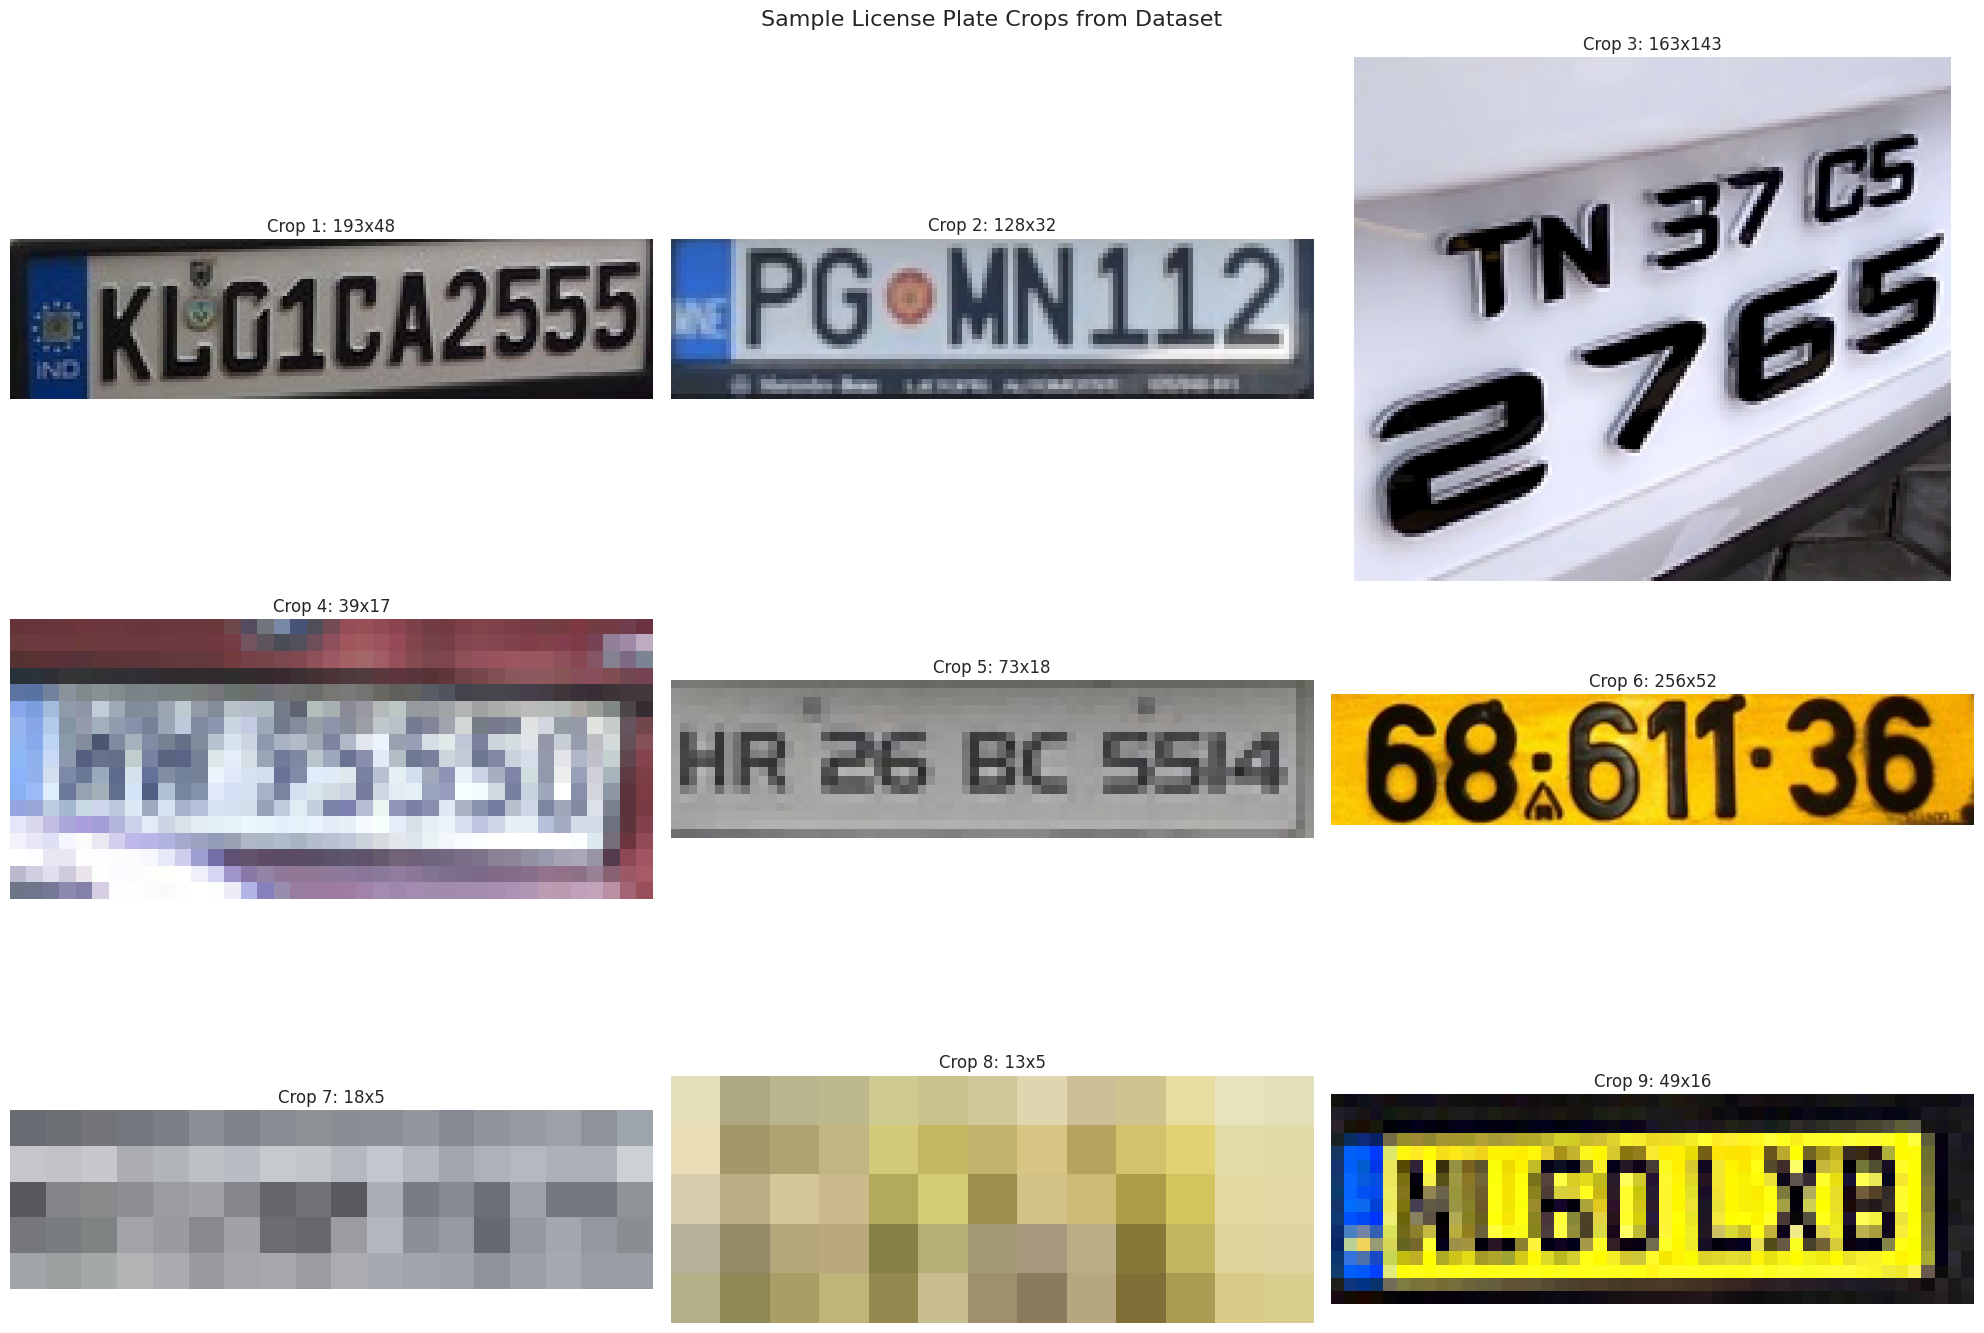

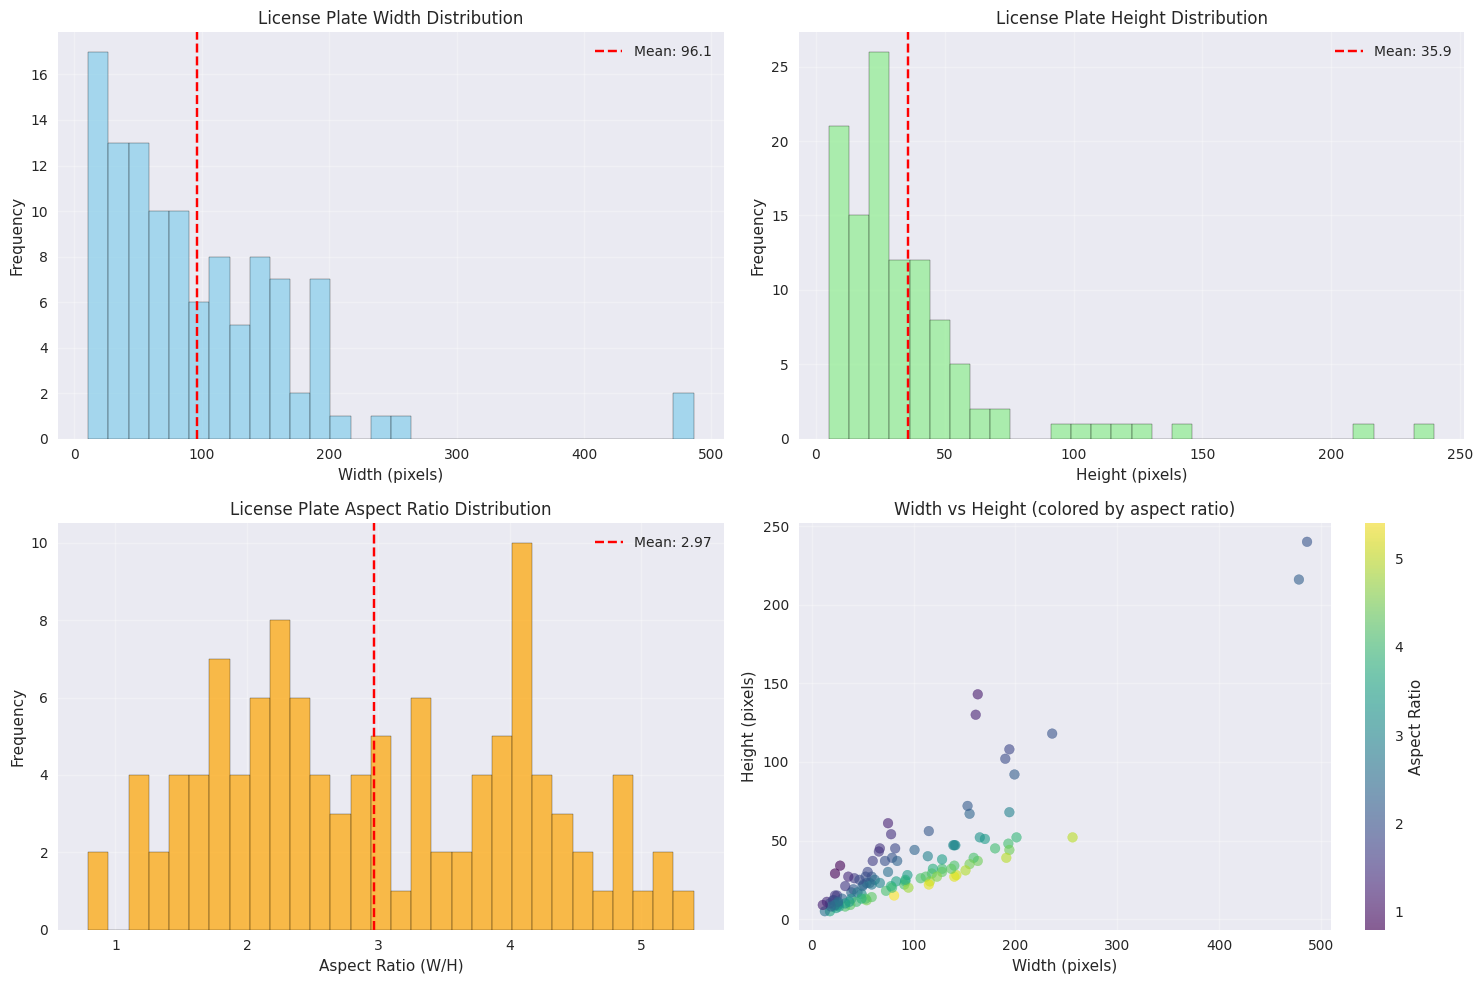

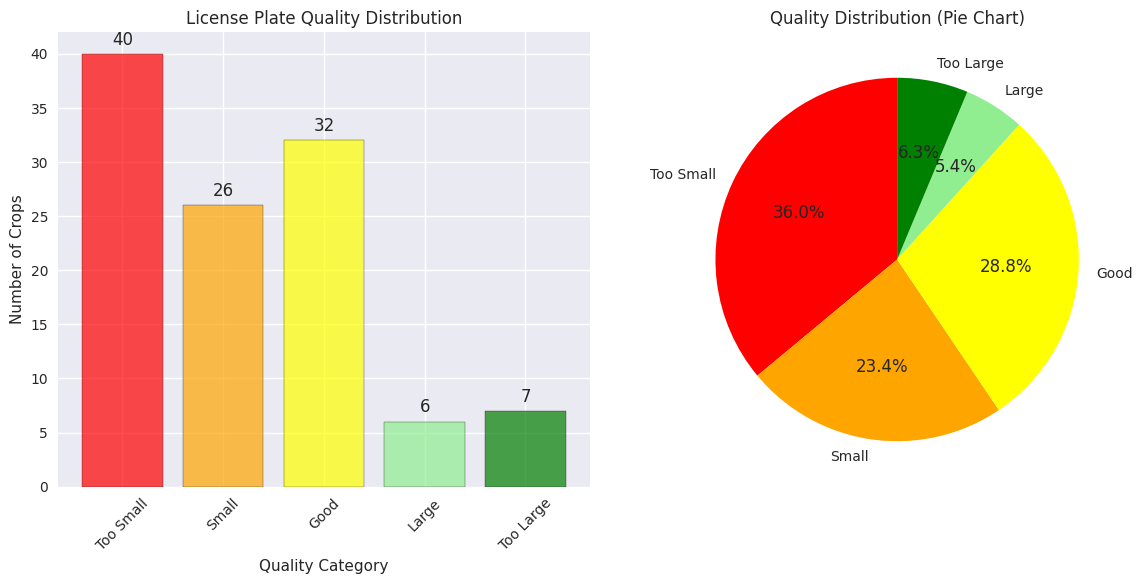


💡 EDA INSIGHTS AND RECOMMENDATIONS
🔍 Key Findings:
   1. Average license plate size: 96x36 pixels
   2. Typical aspect ratio: 2.97 (width/height)
   3. Size variation: Width 11-486, Height 5-240
   4. Data quality: 32/111 (28.8%) crops have good size
   5. Small crops: 66 (59.5%) may need upscaling

 Preprocessing Recommendations:
   • Target input size: 115x43 (120% of average for padding)
   • Minimum size filter: Remove crops smaller than 30x15 pixels
   • Aspect ratio normalization: Target ratio ~3.0
   • Data augmentation: Apply to increase dataset diversity

 Variable-Length Model Considerations:
   • CTC sequence length: Plan for 12-81 time steps
   • Character estimation: 5-194 characters per plate
   • Input standardization: Resize to consistent height, preserve aspect ratio


In [18]:
# =============================================================================
# DATA VISUALIZATION AND EDA INSIGHTS
# =============================================================================

"""
Creating comprehensive visualizations to understand our license plate data.
This helps identify patterns, quality issues, and preprocessing requirements
for building an effective variable-length recognition model.
"""

def create_eda_visualizations(crops, crop_stats, crop_info):
    """Create comprehensive EDA visualizations."""
    
    print(" CREATING EDA VISUALIZATIONS")
    print("=" * 50)
    
    if not crops or not crop_stats:
        print(" No data available for visualization!")
        return
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Sample license plate crops
    for i in range(min(9, len(crops))):
        plt.subplot(3, 3, i+1)
        crop_rgb = cv2.cvtColor(crops[i], cv2.COLOR_BGR2RGB)
        plt.imshow(crop_rgb)
        plt.title(f"Crop {i+1}: {crop_rgb.shape[1]}x{crop_rgb.shape[0]}")
        plt.axis('off')
    
    plt.suptitle('Sample License Plate Crops from Dataset', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # 2. Dimension distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Width distribution
    axes[0, 0].hist(crop_stats['widths'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(np.mean(crop_stats['widths']), color='red', linestyle='--', 
                       label=f"Mean: {np.mean(crop_stats['widths']):.1f}")
    axes[0, 0].set_xlabel('Width (pixels)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('License Plate Width Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Height distribution
    axes[0, 1].hist(crop_stats['heights'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].axvline(np.mean(crop_stats['heights']), color='red', linestyle='--', 
                       label=f"Mean: {np.mean(crop_stats['heights']):.1f}")
    axes[0, 1].set_xlabel('Height (pixels)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('License Plate Height Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Aspect ratio distribution
    axes[1, 0].hist(crop_stats['aspects'], bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].axvline(np.mean(crop_stats['aspects']), color='red', linestyle='--', 
                       label=f"Mean: {np.mean(crop_stats['aspects']):.2f}")
    axes[1, 0].set_xlabel('Aspect Ratio (W/H)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('License Plate Aspect Ratio Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Width vs Height scatter
    scatter = axes[1, 1].scatter(crop_stats['widths'], crop_stats['heights'], 
                                alpha=0.6, c=crop_stats['aspects'], cmap='viridis')
    axes[1, 1].set_xlabel('Width (pixels)')
    axes[1, 1].set_ylabel('Height (pixels)')
    axes[1, 1].set_title('Width vs Height (colored by aspect ratio)')
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 1], label='Aspect Ratio')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Quality analysis
    quality_categories = []
    for w, h in zip(crop_stats['widths'], crop_stats['heights']):
        if w < 50 or h < 20:
            quality_categories.append('Too Small')
        elif w > 300 or h > 100:
            quality_categories.append('Too Large')
        elif w < 80 or h < 25:
            quality_categories.append('Small')
        elif w > 200 or h > 60:
            quality_categories.append('Large')
        else:
            quality_categories.append('Good')
    
    quality_counts = Counter(quality_categories)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']
    categories = ['Too Small', 'Small', 'Good', 'Large', 'Too Large']
    counts = [quality_counts.get(cat, 0) for cat in categories]
    
    bars = plt.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
    plt.xlabel('Quality Category')
    plt.ylabel('Number of Crops')
    plt.title('License Plate Quality Distribution')
    plt.xticks(rotation=45)
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        if count > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom')
    
    plt.subplot(1, 2, 2)
    plt.pie([c for c in counts if c > 0], labels=[cat for cat, c in zip(categories, counts) if c > 0], 
            colors=[col for col, c in zip(colors, counts) if c > 0], autopct='%1.1f%%', startangle=90)
    plt.title('Quality Distribution (Pie Chart)')
    
    plt.tight_layout()
    plt.show()

def generate_eda_insights(crop_stats, crop_info):
    """Generate key insights from the EDA analysis."""
    
    print("\n💡 EDA INSIGHTS AND RECOMMENDATIONS")
    print("=" * 50)
    
    if not crop_stats:
        print(" No data available for insights!")
        return
    
    print("🔍 Key Findings:")
    
    # Size analysis
    avg_width = np.mean(crop_stats['widths'])
    avg_height = np.mean(crop_stats['heights'])
    avg_aspect = np.mean(crop_stats['aspects'])
    
    print(f"   1. Average license plate size: {avg_width:.0f}x{avg_height:.0f} pixels")
    print(f"   2. Typical aspect ratio: {avg_aspect:.2f} (width/height)")
    print(f"   3. Size variation: Width {min(crop_stats['widths'])}-{max(crop_stats['widths'])}, Height {min(crop_stats['heights'])}-{max(crop_stats['heights'])}")
    
    # Quality insights
    small_count = sum(1 for w, h in zip(crop_stats['widths'], crop_stats['heights']) if w < 80 or h < 25)
    good_count = sum(1 for w, h in zip(crop_stats['widths'], crop_stats['heights']) if 80 <= w <= 200 and 25 <= h <= 60)
    
    print(f"   4. Data quality: {good_count}/{crop_stats['total_crops']} ({good_count/crop_stats['total_crops']*100:.1f}%) crops have good size")
    print(f"   5. Small crops: {small_count} ({small_count/crop_stats['total_crops']*100:.1f}%) may need upscaling")
    
    print("\n Preprocessing Recommendations:")
    print(f"   • Target input size: {int(avg_width*1.2)}x{int(avg_height*1.2)} (120% of average for padding)")
    print(f"   • Minimum size filter: Remove crops smaller than 30x15 pixels")
    print(f"   • Aspect ratio normalization: Target ratio ~{avg_aspect:.1f}")
    print(f"   • Data augmentation: Apply to increase dataset diversity")
    
    print("\n Variable-Length Model Considerations:")
    print(f"   • CTC sequence length: Plan for {int(avg_width/8)}-{int(max(crop_stats['widths'])/6)} time steps")
    print(f"   • Character estimation: {int(avg_width/avg_height*2)}-{int(max(crop_stats['widths'])/min(crop_stats['heights'])*2)} characters per plate")
    print(f"   • Input standardization: Resize to consistent height, preserve aspect ratio")

# Create visualizations and insights
if 'license_plate_crops' in locals() and license_plate_crops:
    create_eda_visualizations(license_plate_crops, crop_stats, crop_metadata)
    generate_eda_insights(crop_stats, crop_metadata)
else:
    print(" No license plate crops available for visualization!")


## Let's move to next Part now!

In [ ]:
# # =============================================================================
# # VARIABLE-LENGTH CONFIGURATION FOR CTC
# # =============================================================================

# """
# Setting up the configuration for variable-length license plate recognition.
# This replaces the original fixed NUM_CHARACTERS=7 approach with a flexible
# CTC-based system that can handle plates with 3-12 characters naturally.

# Key Components:
# 1. Variable length parameters (min/max characters)
# 2. Character vocabulary with CTC blank token
# 3. Character encoding/decoding mappings
# 4. Model input/output dimensions
# """

# # Variable-length configuration
# MAX_CHARACTERS = 12  # Maximum license plate length (handles international variations)
# MIN_CHARACTERS = 3   # Minimum license plate length
# NUM_CLASSES = 37     # 26 letters + 10 digits + 1 CTC blank token

# # Model input configuration (based on EDA insights)
# IMG_HEIGHT = 64      # Standardized height for consistent processing
# IMG_WIDTH = 256      # Width to accommodate longest plates with good resolution
# IMG_CHANNELS = 3     # RGB channels

# # Character vocabulary for CTC (blank token at index 0 is crucial for CTC)
# CHARACTERS = ['<BLANK>'] + list('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
# CHAR_TO_NUM = {char: idx for idx, char in enumerate(CHARACTERS)}
# NUM_TO_CHAR = {idx: char for idx, char in enumerate(CHARACTERS)}

# # CTC sequence length (determined by CNN downsampling)
# # After 4 max pooling layers (2x2 each), width is reduced by factor of 16
# SEQUENCE_LENGTH = IMG_WIDTH // 16  # = 16 time steps for CTC

# def print_configuration():
#     """Display the complete variable-length configuration."""
    
#     print(" VARIABLE-LENGTH LPR CONFIGURATION")
#     print("=" * 50)
    
#     print(" Length Parameters:")
#     print(f"   Min characters: {MIN_CHARACTERS}")
#     print(f"   Max characters: {MAX_CHARACTERS}")
#     print(f"   Flexible range: {MAX_CHARACTERS - MIN_CHARACTERS + 1} different lengths supported")
    
#     print("\n  Image Configuration:")
#     print(f"   Input size: {IMG_WIDTH}x{IMG_HEIGHT}x{IMG_CHANNELS}")
#     print(f"   Aspect ratio: {IMG_WIDTH/IMG_HEIGHT:.1f} (width/height)")
#     print(f"   Total pixels: {IMG_WIDTH * IMG_HEIGHT:,}")
    
#     print("\n Character Vocabulary:")
#     print(f"   Total classes: {NUM_CLASSES}")
#     print(f"   Letters: {len([c for c in CHARACTERS[1:] if c.isalpha()])}")
#     print(f"   Digits: {len([c for c in CHARACTERS[1:] if c.isdigit()])}")
#     print(f"   Blank token: {CHARACTERS[0]} (index 0)")
#     print(f"   Character set: {''.join(CHARACTERS[1:])}")
    
#     print("\n CTC Configuration:")
#     print(f"   Sequence length: {SEQUENCE_LENGTH} time steps")
#     print(f"   Downsampling factor: {IMG_WIDTH // SEQUENCE_LENGTH}x")
#     print(f"   Characters per time step: ~{MAX_CHARACTERS / SEQUENCE_LENGTH:.1f}")
    
#     print("\n Advantages over Fixed-Length:")
#     print("   • No padding/truncation needed")
#     print("   • Automatic alignment learning")
#     print("   • Handles real-world variations")
#     print("   • More efficient parameter usage")
#     print("   • Robust to different plate formats")

# def validate_configuration():
#     """Validate that the configuration makes sense."""
    
#     print(f"\n CONFIGURATION VALIDATION")
#     print("=" * 50)
    
#     # Check character vocabulary
#     assert len(CHARACTERS) == NUM_CLASSES, f"Character count mismatch: {len(CHARACTERS)} != {NUM_CLASSES}"
#     assert CHARACTERS[0] == '<BLANK>', "Blank token must be at index 0 for CTC"
    
#     # Check sequence length viability
#     min_time_steps_needed = MIN_CHARACTERS
#     max_time_steps_needed = MAX_CHARACTERS
    
#     print(f" Character vocabulary: {len(CHARACTERS)} classes defined correctly")
#     print(f" CTC blank token: '{CHARACTERS[0]}' at index 0")
#     print(f" Sequence length: {SEQUENCE_LENGTH} steps (min needed: {min_time_steps_needed}, max needed: {max_time_steps_needed})")
    
#     if SEQUENCE_LENGTH >= max_time_steps_needed:
#         print(f" Sequence length adequate for {MAX_CHARACTERS}-character plates")
#     else:
#         print(f"  Sequence length may be tight for longest plates")
    
#     # Check input dimensions
#     total_params_estimate = IMG_WIDTH * IMG_HEIGHT * IMG_CHANNELS
#     print(f" Input dimensions: {total_params_estimate:,} input parameters")
    
#     return True

# # Display and validate configuration
# print_configuration()
# validation_passed = validate_configuration()

# if validation_passed:
#     print(f"\n CONFIGURATION READY FOR VARIABLE-LENGTH LPR!")
# else:
#     print(f"\n Configuration validation failed!")


 VARIABLE-LENGTH LPR CONFIGURATION
 Length Parameters:
   Min characters: 3
   Max characters: 12
   Flexible range: 10 different lengths supported

  Image Configuration:
   Input size: 256x64x3
   Aspect ratio: 4.0 (width/height)
   Total pixels: 16,384

 Character Vocabulary:
   Total classes: 37
   Letters: 26
   Digits: 10
   Blank token: <BLANK> (index 0)
   Character set: ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789

 CTC Configuration:
   Sequence length: 16 time steps
   Downsampling factor: 16x
   Characters per time step: ~0.8

 Advantages over Fixed-Length:
   • No padding/truncation needed
   • Automatic alignment learning
   • Handles real-world variations
   • More efficient parameter usage
   • Robust to different plate formats

 CONFIGURATION VALIDATION
 Character vocabulary: 37 classes defined correctly
 CTC blank token: '<BLANK>' at index 0
 Sequence length: 16 steps (min needed: 3, max needed: 12)
 Sequence length adequate for 12-character plates
 Input dimensions: 49,152 i

In [ ]:
# import os
# import pickle
# import joblib
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import string

# # =============================================================================
# # CONFIGURATION
# # =============================================================================

# # Image dimensions for model input
# IMG_HEIGHT = 64
# IMG_WIDTH = 256
# IMG_CHANNELS = 3

# # License plate specifications
# MIN_CHARACTERS = 3
# MAX_CHARACTERS = 12

# # Character set for license plates (alphanumeric)
# CHARACTERS = string.ascii_uppercase + string.digits
# NUM_CLASSES = len(CHARACTERS) + 1  # +1 for CTC blank token
# CHAR_TO_IDX = {
#     char: idx + 1 for idx, char in enumerate(CHARACTERS)
# }  # Start from 1, 0 is blank
# IDX_TO_CHAR = {idx + 1: char for idx, char in enumerate(CHARACTERS)}
# CHAR_TO_IDX[""] = 0  # Blank token
# IDX_TO_CHAR[0] = ""  # Blank token

# print(f"📝 Character set: {CHARACTERS}")
# print(f"   Total classes (including blank): {NUM_CLASSES}")

# # =============================================================================
# # CTC MODEL ARCHITECTURE
# # =============================================================================


# def create_ctc_model():
#     """
#     Create the CTC-based variable-length license plate recognition model.

#     Returns:
#         keras.Model: Compiled CTC model ready for training
#     """

#     print("🧠 BUILDING CTC MODEL ARCHITECTURE")
#     print("=" * 50)

#     # Input layer
#     inputs = keras.Input(
#         shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="image_input"
#     )
#     print(f"    Input: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")

#     # CNN Feature Extraction Backbone
#     # Block 1: Initial feature extraction
#     x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv1_1")(
#         inputs
#     )
#     x = layers.BatchNormalization(name="bn1_1")(x)
#     x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv1_2")(x)
#     x = layers.BatchNormalization(name="bn1_2")(x)
#     x = layers.MaxPooling2D((2, 2), name="pool1")(x)
#     x = layers.Dropout(0.25, name="dropout1")(x)

#     # Block 2: Deeper features
#     x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="conv2_1")(x)
#     x = layers.BatchNormalization(name="bn2_1")(x)
#     x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="conv2_2")(x)
#     x = layers.BatchNormalization(name="bn2_2")(x)
#     x = layers.MaxPooling2D((2, 2), name="pool2")(x)
#     x = layers.Dropout(0.25, name="dropout2")(x)

#     # Block 3: Complex features
#     x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="conv3_1")(x)
#     x = layers.BatchNormalization(name="bn3_1")(x)
#     x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="conv3_2")(x)
#     x = layers.BatchNormalization(name="bn3_2")(x)
#     x = layers.MaxPooling2D((2, 2), name="pool3")(x)
#     x = layers.Dropout(0.25, name="dropout3")(x)

#     # Block 4: High-level features
#     x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="conv4_1")(x)
#     x = layers.BatchNormalization(name="bn4_1")(x)
#     x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="conv4_2")(x)
#     x = layers.BatchNormalization(name="bn4_2")(x)
#     x = layers.MaxPooling2D((2, 2), name="pool4")(x)
#     x = layers.Dropout(0.25, name="dropout4")(x)

#     # Calculate feature map dimensions after CNN
#     feature_height = IMG_HEIGHT // 16  # 4 pooling layers (2^4 = 16)
#     feature_width = IMG_WIDTH // 16  # Same downsampling
#     feature_channels = 256

#     print(f"    CNN Output: {feature_width}x{feature_height}x{feature_channels}")

#     # Reshape for RNN input: (batch, time_steps, features)
#     # We treat width as time dimension for sequence processing
#     new_shape = (feature_width, feature_height * feature_channels)
#     x = layers.Reshape(target_shape=new_shape, name="reshape_for_rnn")(x)

#     print(f"    Reshaped: {new_shape[0]} time steps, {new_shape[1]} features per step")

#     # Dense layer to reduce feature dimensionality before RNN
#     x = layers.Dense(128, activation="relu", name="dense_before_rnn")(x)
#     x = layers.Dropout(0.25, name="dropout_before_rnn")(x)

#     # RNN Layers for Sequence Modeling
#     # Bidirectional LSTMs learn both forward and backward dependencies
#     x = layers.Bidirectional(
#         layers.LSTM(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.25),
#         name="bidirectional_lstm_1",
#     )(x)

#     x = layers.Bidirectional(
#         layers.LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.25),
#         name="bidirectional_lstm_2",
#     )(x)

#     print(
#         f"    RNN Output: {feature_width} time steps, 128 features (64x2 bidirectional)"
#     )

#     # CTC Output Layer
#     # This outputs probability distributions over characters at each time step
#     outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="ctc_output")(x)

#     print(
#         f"    CTC Output: {feature_width} time steps, {NUM_CLASSES} character classes"
#     )

#     # Create the model
#     model = keras.Model(inputs=inputs, outputs=outputs, name="variable_length_lpr_ctc")

#     print(f"    Model created: {model.count_params():,} total parameters")

#     return model


# def create_ctc_loss_function():
#     """
#     Create a CTC loss function for training.

#     CTC loss automatically handles:
#     - Variable sequence lengths
#     - Character alignment
#     - Blank token insertion
#     """

#     def ctc_loss(y_true, y_pred):
#         """Custom CTC loss function."""
#         # Ensure labels are integers (fix for TensorFlow type error)
#         y_true = tf.cast(y_true, tf.int32)

#         # Calculate sequence lengths
#         batch_size = tf.shape(y_true)[0]
#         input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
#         label_length = tf.reduce_sum(tf.cast(y_true != -1, tf.int32), axis=1)

#         # Compute CTC loss
#         loss = tf.nn.ctc_loss(
#             labels=y_true,
#             logits=y_pred,
#             label_length=label_length,
#             logit_length=input_length,
#             blank_index=0,
#             logits_time_major=False,
#         )

#         return tf.reduce_mean(loss)

#     return ctc_loss


# # =============================================================================
# # MODEL SAVING AND EXPORT
# # =============================================================================


# def save_model_multiple_formats(model, model_name="ctc_license_plate_model"):
#     """Save model in multiple formats including pickle"""

#     print("💾 SAVING MODEL IN MULTIPLE FORMATS")
#     print("=" * 50)

#     # Create directories
#     os.makedirs("models", exist_ok=True)
#     os.makedirs("exports", exist_ok=True)

#     # 1. Save as Keras H5 format
#     h5_path = f"models/{model_name}.h5"
#     model.save(h5_path)
#     print(f"✅ Saved Keras H5 model: {h5_path}")

#     # 2. Save as TensorFlow SavedModel format (requires compiled model)
#     try:
#         savedmodel_path = f"models/{model_name}_savedmodel"
#         tf.saved_model.save(model, savedmodel_path)
#         print(f"✅ Saved TensorFlow SavedModel: {savedmodel_path}")
#     except Exception as e:
#         print(f"⚠️ Could not save TensorFlow SavedModel (model not compiled): {e}")
#         savedmodel_path = None

#     # 3. Save model weights only
#     weights_path = f"models/{model_name}.weights.h5"
#     model.save_weights(weights_path)
#     print(f"✅ Saved model weights: {weights_path}")

#     # 4. Save model architecture as JSON
#     architecture_path = f"models/{model_name}_architecture.json"
#     with open(architecture_path, "w") as f:
#         f.write(model.to_json())
#     print(f"✅ Saved model architecture: {architecture_path}")

#     # 5. Save model as pickle (complete model data)
#     try:
#         model_data = {
#             "architecture": model.to_json(),
#             "weights": model.get_weights(),
#             "char_to_idx": CHAR_TO_IDX,
#             "idx_to_char": IDX_TO_CHAR,
#             "img_height": IMG_HEIGHT,
#             "img_width": IMG_WIDTH,
#             "img_channels": IMG_CHANNELS,
#             "num_classes": NUM_CLASSES,
#         }

#         pickle_path = f"exports/{model_name}_complete.pkl"
#         with open(pickle_path, "wb") as f:
#             pickle.dump(model_data, f)
#         print(f"✅ Saved complete model data as pickle: {pickle_path}")

#         # Also save with joblib (better for large numpy arrays)
#         joblib_path = f"exports/{model_name}_complete.joblib"
#         joblib.dump(model_data, joblib_path)
#         print(f"✅ Saved complete model data as joblib: {joblib_path}")

#     except Exception as e:
#         print(f"⚠️ Could not save as pickle: {e}")

#     # 6. Save configuration and metadata
#     config = {
#         "model_name": model_name,
#         "img_height": IMG_HEIGHT,
#         "img_width": IMG_WIDTH,
#         "img_channels": IMG_CHANNELS,
#         "num_classes": NUM_CLASSES,
#         "characters": CHARACTERS,
#         "char_to_idx": CHAR_TO_IDX,
#         "idx_to_char": IDX_TO_CHAR,
#         "min_characters": MIN_CHARACTERS,
#         "max_characters": MAX_CHARACTERS,
#         "model_params": model.count_params(),
#     }

#     config_path = f"exports/{model_name}_config.json"
#     with open(config_path, "w") as f:
#         import json

#         json.dump(config, f, indent=2)
#     print(f"✅ Saved model configuration: {config_path}")

#     print(f"\n🎯 Model saved in 6 different formats!")
#     return {
#         "h5": h5_path,
#         "savedmodel": savedmodel_path,
#         "weights": weights_path,
#         "architecture": architecture_path,
#         "pickle": pickle_path,
#         "config": config_path,
#     }


# def load_model_from_pickle(pickle_path):
#     """Load model from pickle file"""
#     print(f"📥 Loading model from pickle: {pickle_path}")

#     # Load model data
#     with open(pickle_path, "rb") as f:
#         model_data = pickle.load(f)

#     # Recreate model from architecture
#     model = keras.models.model_from_json(model_data["architecture"])

#     # Set weights
#     model.set_weights(model_data["weights"])

#     # Restore configuration
#     global CHAR_TO_IDX, IDX_TO_CHAR, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES
#     CHAR_TO_IDX = model_data["char_to_idx"]
#     IDX_TO_CHAR = model_data["idx_to_char"]
#     IMG_HEIGHT = model_data["img_height"]
#     IMG_WIDTH = model_data["img_width"]
#     IMG_CHANNELS = model_data["img_channels"]
#     NUM_CLASSES = model_data["num_classes"]

#     print("✅ Model loaded successfully from pickle")
#     return model


# # =============================================================================
# # MAIN EXECUTION FOR DEMO
# # =============================================================================

# if __name__ == "__main__":
#     print("🚀 CTC MODEL ARCHITECTURE & EXPORT")
#     print("=" * 50)

#     # Create the CTC model
#     print("📋 Creating Variable-Length CTC Model...")
#     ctc_model = create_ctc_model()
#     ctc_loss_fn = create_ctc_loss_function()

#     # Display model summary
#     print("\n🏗️ MODEL ARCHITECTURE SUMMARY:")
#     ctc_model.summary()

#     print("\n✅ CTC Model Components Ready:")
#     print("   • Model architecture: CNN + RNN + CTC")
#     print("   • Loss function: CTC loss with automatic alignment")
#     print(f"   • Supports: {MIN_CHARACTERS}-{MAX_CHARACTERS} character license plates")

#     # Save model in multiple formats
#     print("\n" + "=" * 60)
#     saved_paths = save_model_multiple_formats(ctc_model, "ctc_license_plate_model_v1")

#     print("\n🎉 COMPLETE! Model architecture created and saved in multiple formats.")
#     print("   Ready for training in your notebook!")


📝 Character set: ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
   Total classes (including blank): 37
🚀 CTC MODEL ARCHITECTURE & EXPORT
📋 Creating Variable-Length CTC Model...
🧠 BUILDING CTC MODEL ARCHITECTURE
    Input: 64x256x3
    CNN Output: 16x4x256
    Reshaped: 16 time steps, 1024 features per step
    RNN Output: 16 time steps, 128 features (64x2 bidirectional)
    CTC Output: 16 time steps, 37 character classes
    Model created: 1,739,589 total parameters

🏗️ MODEL ARCHITECTURE SUMMARY:


Model: "variable_length_lpr_ctc"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 64, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 64, 256, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 64, 256, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 64, 256, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 64, 256, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 32, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 32, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 32, 128, 64)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 32, 128, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 32, 128, 64)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 16, 64, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 16, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 16, 64, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4_1 (BatchNormalization)      │ (None, 8, 32, 256)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_2 (Conv2D)                │ (None, 8, 32, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4_2 (BatchNormalization)      │ (None, 8, 32, 256)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 4, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 4, 16, 256)     │             

 Total params: 1,739,589 (6.64 MB)

 Trainable params: 1,737,669 (6.63 MB)

 Non-trainable params: 1,920 (7.50 KB)


✅ CTC Model Components Ready:
   • Model architecture: CNN + RNN + CTC
   • Loss function: CTC loss with automatic alignment
   • Supports: 3-12 character license plates

💾 SAVING MODEL IN MULTIPLE FORMATS
✅ Saved Keras H5 model: models/ctc_license_plate_model_v1.h5
⚠️ Could not save TensorFlow SavedModel (model not compiled): this __dict__ descriptor does not support '_DictWrapper' objects
✅ Saved model weights: models/ctc_license_plate_model_v1.weights.h5
✅ Saved model architecture: models/ctc_license_plate_model_v1_architecture.json
✅ Saved complete model data as pickle: exports/ctc_license_plate_model_v1_complete.pkl
✅ Saved complete model data as joblib: exports/ctc_license_plate_model_v1_complete.joblib
✅ Saved model configuration: exports/ctc_license_plate_model_v1_config.json

🎯 Model saved in 6 different formats!

🎉 COMPLETE! Model architecture created and saved in multiple formats.
   Ready for training in your notebook!


IndentationError: unexpected indent (694581230.py, line 198)